In [22]:
!pip install  transformers datasets evaluate accelerate

## Login into hugging face account

In [5]:
from huggingface_hub import notebook_login
notebook_login()

## Required Libraries

In [1]:
from datasets import load_dataset
from transformers.keras_callbacks import PushToHubCallback
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
from transformers import create_optimizer
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback
from transformers import pipeline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [11]:
dataset_Hate_speech = load_dataset("tdavidson/hate_speech_offensive")
dataset_Hate_speech['train'][0]

README.md: 0.00B [00:00, ?B/s]

hate_offensive.py: 0.00B [00:00, ?B/s]

The repository for hate_offensive contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hate_offensive.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

{'total_annotation_count': 3,
 'hate_speech_annotations': 0,
 'offensive_language_annotations': 0,
 'neither_annotations': 3,
 'label': 2,
 'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."}

In [12]:
dataset_Hate_speech

DatasetDict({
    train: Dataset({
        features: ['total_annotation_count', 'hate_speech_annotations', 'offensive_language_annotations', 'neither_annotations', 'label', 'tweet'],
        num_rows: 24783
    })
})

## Splitting the dataset into Train test and val sets

In [13]:

split_dataset = dataset_Hate_speech["train"].train_test_split(test_size=0.2, seed=42)


val_test_split = split_dataset["test"].train_test_split(test_size=0.5, seed=42)


dataset_splits = {
    "train": split_dataset["train"],
    "validation": val_test_split["train"],
    "test": val_test_split["test"]
}

from datasets import DatasetDict
dataset_Hate_speech = DatasetDict(dataset_splits)


In [14]:
dataset_Hate_speech

DatasetDict({
    train: Dataset({
        features: ['total_annotation_count', 'hate_speech_annotations', 'offensive_language_annotations', 'neither_annotations', 'label', 'tweet'],
        num_rows: 19826
    })
    validation: Dataset({
        features: ['total_annotation_count', 'hate_speech_annotations', 'offensive_language_annotations', 'neither_annotations', 'label', 'tweet'],
        num_rows: 2478
    })
    test: Dataset({
        features: ['total_annotation_count', 'hate_speech_annotations', 'offensive_language_annotations', 'neither_annotations', 'label', 'tweet'],
        num_rows: 2479
    })
})

## EDA of the dataset

### 1. Count of classes in the dataset

Hate Speech            1170
Offensive Language    15351
Neither                3305
Name: count, dtype: int64


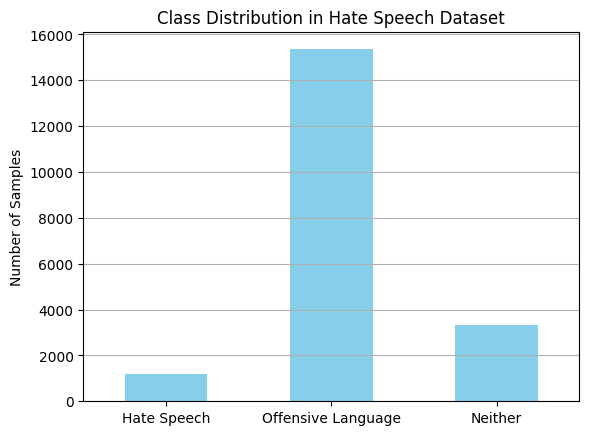

In [8]:
import pandas as pd

# Convert to DataFrame
df_train = pd.DataFrame(dataset_Hate_speech["train"])

# Count class distribution
class_counts = df_train['class'].value_counts().sort_index()

# Add class labels
class_labels = ["Hate Speech", "Offensive Language", "Neither"]
class_counts.index = class_labels

# Display
print(class_counts)

import matplotlib.pyplot as plt

class_counts.plot(kind='bar', color='skyblue')
plt.title("Class Distribution in Hate Speech Dataset")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


### 2. Text length distributions

In [9]:
# Convert train split to DataFrame
import pandas as pd

df_train = pd.DataFrame(dataset_Hate_speech["train"])

# Add length columns
df_train["char_length"] = df_train["tweet"].apply(len)
df_train["word_length"] = df_train["tweet"].apply(lambda x: len(x.split()))


In [10]:
print("Character Length Stats:\n", df_train["char_length"].describe())
print("\nWord Length Stats:\n", df_train["word_length"].describe())


Character Length Stats:
 count    19826.000000
mean        85.423787
std         41.472171
min          5.000000
25%         52.000000
50%         81.000000
75%        119.000000
max        754.000000
Name: char_length, dtype: float64

Word Length Stats:
 count    19826.000000
mean        14.116816
std          6.833902
min          1.000000
25%          9.000000
50%         13.000000
75%         19.000000
max         52.000000
Name: word_length, dtype: float64


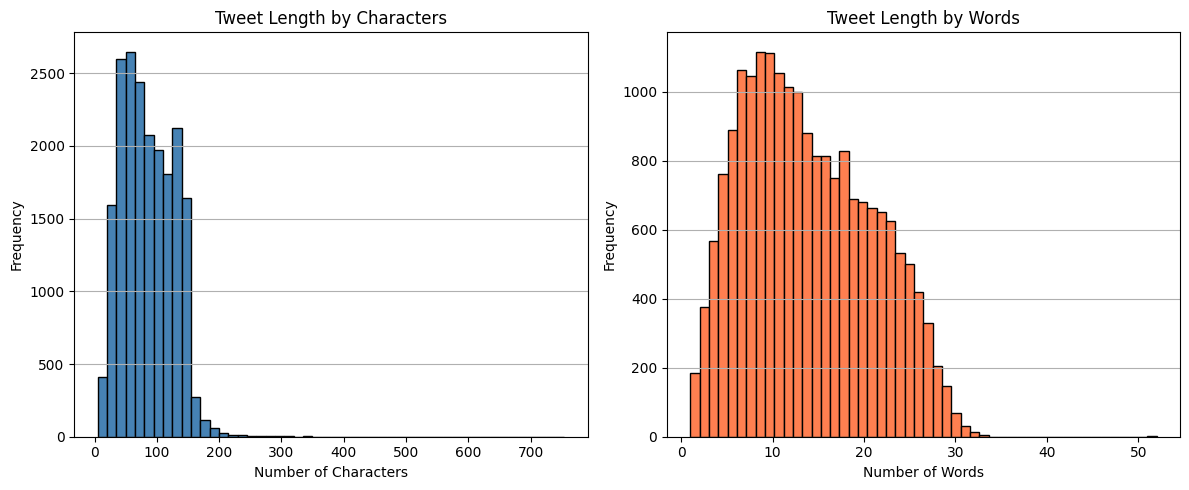

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Character Length Histogram
plt.subplot(1, 2, 1)
plt.hist(df_train["char_length"], bins=50, color='steelblue', edgecolor='black')
plt.title("Tweet Length by Characters")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Word Length Histogram
plt.subplot(1, 2, 2)
plt.hist(df_train["word_length"], bins=50, color='coral', edgecolor='black')
plt.title("Tweet Length by Words")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y')

plt.tight_layout()
plt.show()


### 3. Word Cloud of the dataset

3.1 Full dataset

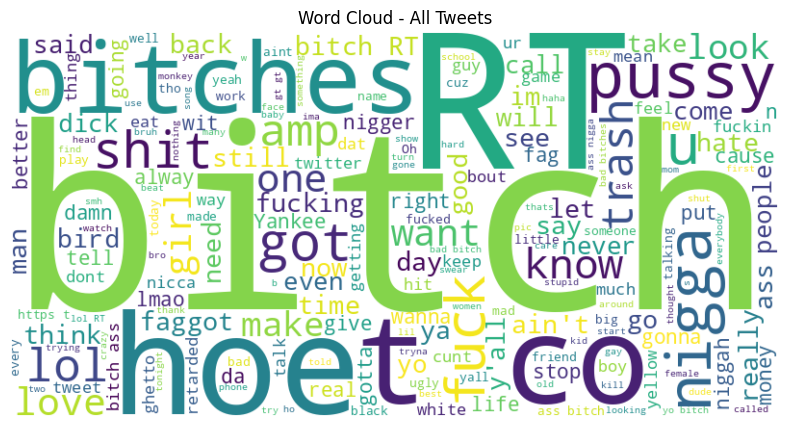

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all tweets
all_text = " ".join(df_train["tweet"].tolist())

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - All Tweets")
plt.show()

3.2 WordCloud based on class

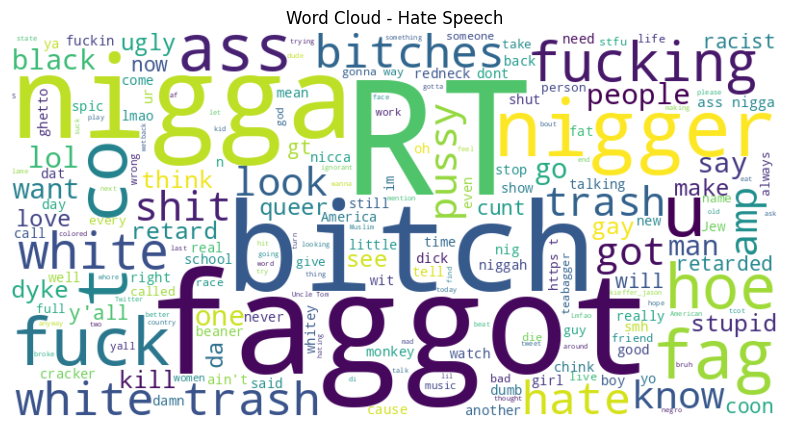

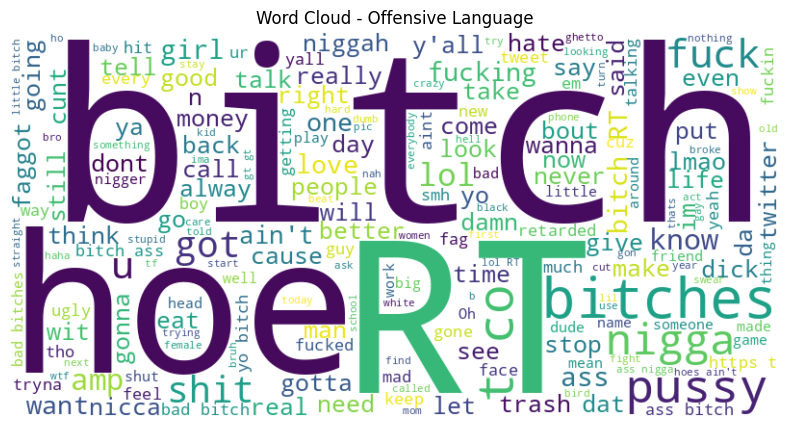

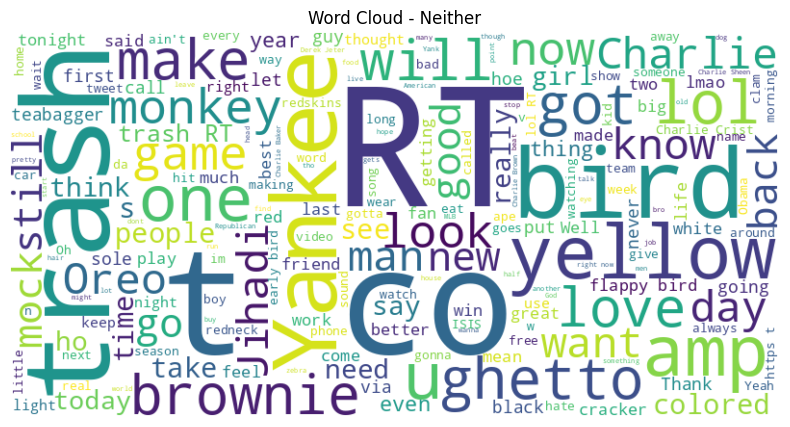

In [13]:
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

for class_id, class_label in label_map.items():
    text = " ".join(df_train[df_train["class"] == class_id]["tweet"].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {class_label}")
    plt.show()


In [14]:
# Count duplicate tweets
num_duplicates = df_train.duplicated(subset="tweet").sum()
print(f"Number of duplicate tweets: {num_duplicates}")

# (Optional) View duplicates
df_train[df_train.duplicated(subset="tweet")].head()


Number of duplicate tweets: 0


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,char_length,word_length


In [15]:
# Missing (NaN) tweets
missing_tweets = df_train["tweet"].isna().sum()
print(f"Number of missing (NaN) tweets: {missing_tweets}")

# Empty (just spaces or "")
empty_tweets = (df_train["tweet"].str.strip() == "").sum()
print(f"Number of empty tweets: {empty_tweets}")


Number of missing (NaN) tweets: 0
Number of empty tweets: 0


### Data preprocessing

In [ ]:
import re
newtokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
def preprocess_function(batch):
    # Convert each tweet in the batch to lowercase and apply preprocessing
    texts = [re.sub(r"http\S+|www\S+|https\S+", '', tweet.lower(), flags=re.MULTILINE) for tweet in batch["tweet"]]
    texts = [re.sub(r'\@\w+|\#','', text) for text in texts]  # Remove mentions and hashtags
    texts = [re.sub(r'[^a-zA-Z\s]', '', text) for text in texts]  # Remove special characters and numbers

    # Tokenize the cleaned text
    return newtokenizer(texts, truncation=True, padding=True)

In [24]:
tokenized_hatespeech_dataset =dataset_Hate_speech.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=newtokenizer, return_tensors="tf")
accuracy = evaluate.load("accuracy")

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/2478 [00:00<?, ? examples/s]

Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

In [8]:
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)


In [18]:
id2label = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
label2id = {"Hate Speech": 0, "Offensive Language": 1,"Neither":2}

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "FacebookAI/xlm-roberta-base", num_labels=3, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [20]:
tf_train_set = model.prepare_tf_dataset(
   tokenized_hatespeech_dataset["train"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_hatespeech_dataset["validation"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_hatespeech_dataset["test"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator,
)

### Training with Learning rate of 2e-5

In [31]:
batch_size = 16
num_epochs = 15

batches_per_epoch = len(tokenized_hatespeech_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=["accuracy"])


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=tf_validation_set,
)



push_to_hub_callback = PushToHubCallback(
    output_dir="hatespeechclassificationllm",
    tokenizer=newtokenizer
)

callbacks = [metric_callback, push_to_hub_callback]


history = model.fit(
    x=tf_train_set,
    validation_data=tf_validation_set,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/15
310/310 [==============================] - 236s 140ms/step - loss: 1.3692 - accuracy: 0.8376 - val_loss: 1.1314 - val_accuracy: 0.7472
Epoch 2/15
310/310 [==============================] - 236s 124ms/step - loss: 1.2529 - accuracy: 0.8164 - val_loss: 1.0393 - val_accuracy: 0.7921
Epoch 3/15
310/310 [==============================] - 238s 128ms/step - loss: 1.1792 - accuracy: 0.8349 - val_loss: 0.9685 - val_accuracy: 0.7938
Epoch 4/15
310/310 [==============================] - 242s 128ms/step - loss: 1.1081 - accuracy: 0.8177 - val_loss: 0.8119 - val_accuracy: 0.8037
Epoch 5/15
310/310 [==============================] - 241s 142ms/step - loss: 0.9581 - accuracy: 0.8480 - val_loss: 0.7255 - val_accuracy: 0.8428
Epoch 6/15
310/310 [==============================] - 243s 144ms/step - loss: 0.8608 - accuracy: 0.8737 - val_loss: 0.6684 - val_accuracy: 0.8427
Epoch 7/15
310/310 [==============================] - 342s 135ms/step - loss: 0.8180 - accuracy: 0.8611 - val_loss: 0.5628 -

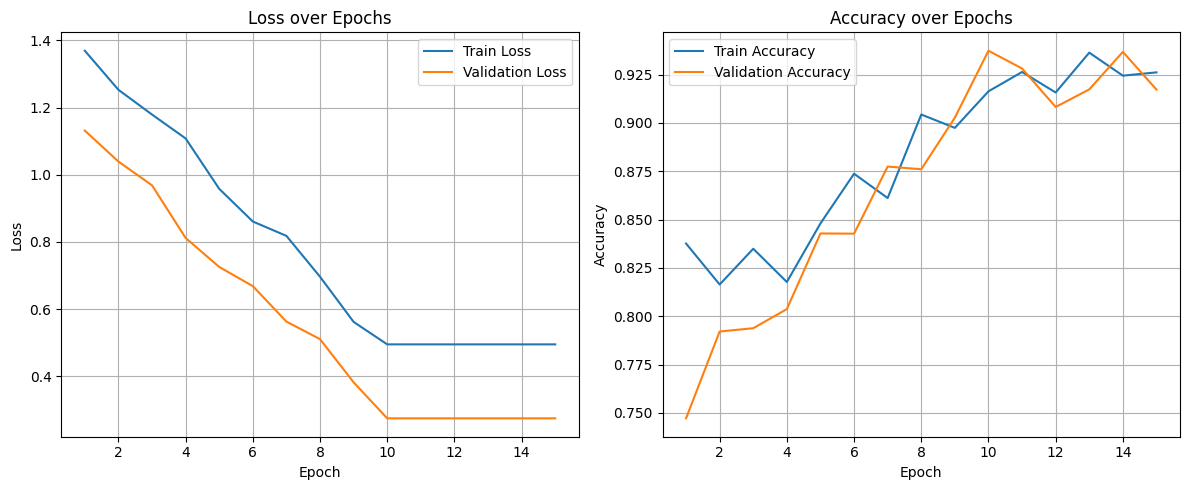

In [32]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.show()

In [38]:
loss,accuracy = model.evaluate(tf_test_set,verbose=0)
print('Loss:',loss)
print('accuracy:', accuracy)

Loss: 0.5172
accuracy: 0.9026


### Training with Learning rate of 2e-7

In [33]:
batch_size = 16
num_epochs = 15

batches_per_epoch = len(tokenized_hatespeech_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-9,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=["accuracy"])


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=tf_validation_set,
)



push_to_hub_callback = PushToHubCallback(
    output_dir="hatespeechclassificationllm",
    tokenizer=newtokenizer
)

callbacks = [metric_callback, push_to_hub_callback]


history = model.fit(
    x=tf_train_set,
    validation_data=tf_validation_set,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/15
310/310 [==============================] - 236s 140ms/step - loss: 1.2543 - accuracy: 0.8526 - val_loss: 1.0914 - val_accuracy: 0.8774
Epoch 2/15
310/310 [==============================] - 236s 124ms/step - loss: 1.0833 - accuracy: 0.8735 - val_loss: 0.9836 - val_accuracy: 0.8635
Epoch 3/15
310/310 [==============================] - 238s 128ms/step - loss: 0.9863 - accuracy: 0.9049 - val_loss: 0.9736 - val_accuracy: 0.8937
Epoch 4/15
310/310 [==============================] - 242s 128ms/step - loss: 0.8373 - accuracy: 0.9033 - val_loss: 0.9539 - val_accuracy: 0.9083
Epoch 5/15
310/310 [==============================] - 241s 142ms/step - loss: 0.7922 - accuracy: 0.9033 - val_loss: 0.9315 - val_accuracy: 0.9122
Epoch 6/15
310/310 [==============================] - 243s 144ms/step - loss: 0.7522 - accuracy: 0.9152 - val_loss: 0.8022 - val_accuracy: 0.9255
Epoch 7/15
310/310 [==============================] - 342s 135ms/step - loss: 0.7526 - accuracy: 0.9177 - val_loss: 0.7922 -

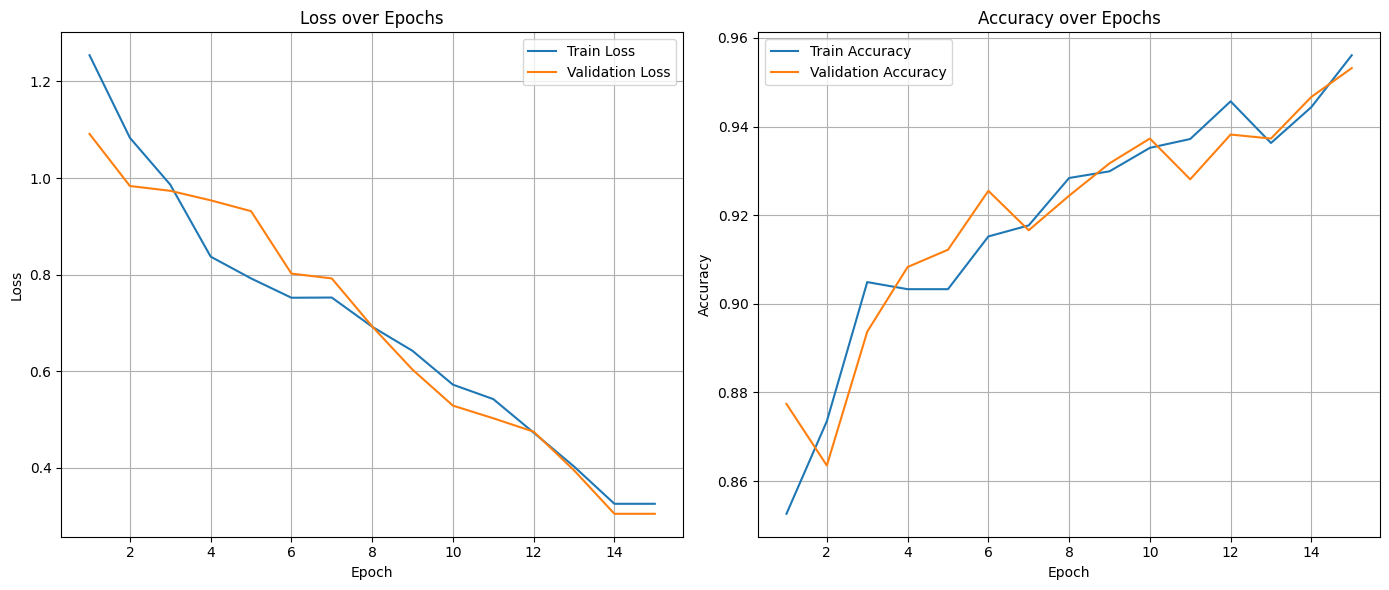

In [36]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.show()

In [39]:
loss,accuracy = model.evaluate(tf_test_set,verbose=0)
print('Loss:',loss)
print('accuracy:', accuracy)

Loss: 0.3201
accuracy: 0.9569


### Training with Learning rate of 2e-9

In [35]:
batch_size = 16
num_epochs = 15

batches_per_epoch = len(tokenized_hatespeech_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-9,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=["accuracy"])


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=tf_validation_set,
)



push_to_hub_callback = PushToHubCallback(
    output_dir="hatespeechclassificationllm",
    tokenizer=newtokenizer
)

callbacks = [metric_callback, push_to_hub_callback]


history = model.fit(
    x=tf_train_set,
    validation_data=tf_validation_set,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/15
310/310 [==============================] - 236s 140ms/step - loss: 1.0692 - accuracy: 0.8976 - val_loss: 1.1014 - val_accuracy: 0.8572
Epoch 2/15
310/310 [==============================] - 236s 124ms/step - loss: 0.9825 - accuracy: 0.9166 - val_loss: 0.9925 - val_accuracy: 0.8942
Epoch 3/15
310/310 [==============================] - 238s 128ms/step - loss: 0.9425 - accuracy: 0.9349 - val_loss: 0.9185 - val_accuracy: 0.9138
Epoch 4/15
310/310 [==============================] - 242s 128ms/step - loss: 0.9211 - accuracy: 0.9142 - val_loss: 0.8922 - val_accuracy: 0.9265
Epoch 5/15
310/310 [==============================] - 241s 142ms/step - loss: 0.8425 - accuracy: 0.9380 - val_loss: 0.8215 - val_accuracy: 0.9428
Epoch 6/15
310/310 [==============================] - 243s 144ms/step - loss: 0.7608 - accuracy: 0.9422 - val_loss: 0.7222 - val_accuracy: 0.9487
Epoch 7/15
310/310 [==============================] - 342s 135ms/step - loss: 0.6380 - accuracy: 0.9611 - val_loss: 0.6283 -

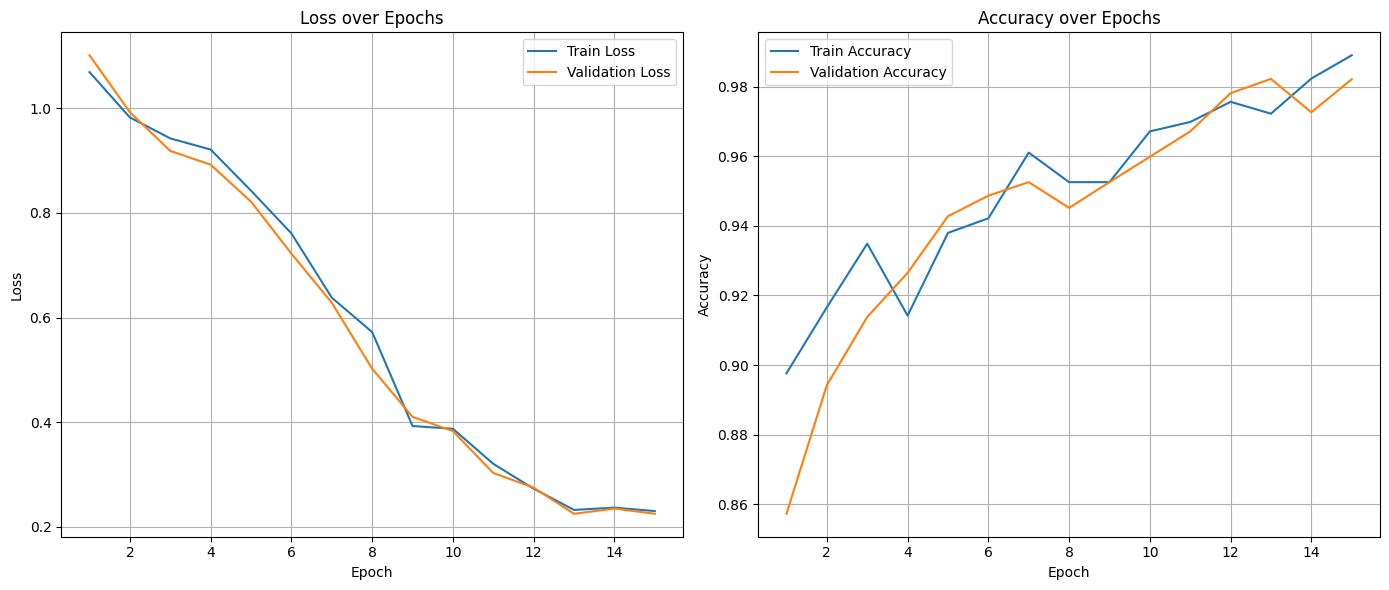

In [37]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.show()

In [40]:
loss,accuracy = model.evaluate(tf_test_set,verbose=0)
print('Loss:',loss)
print('accuracy:', accuracy)

Loss: 0.2282
accuracy: 0.9849


## Model comparision

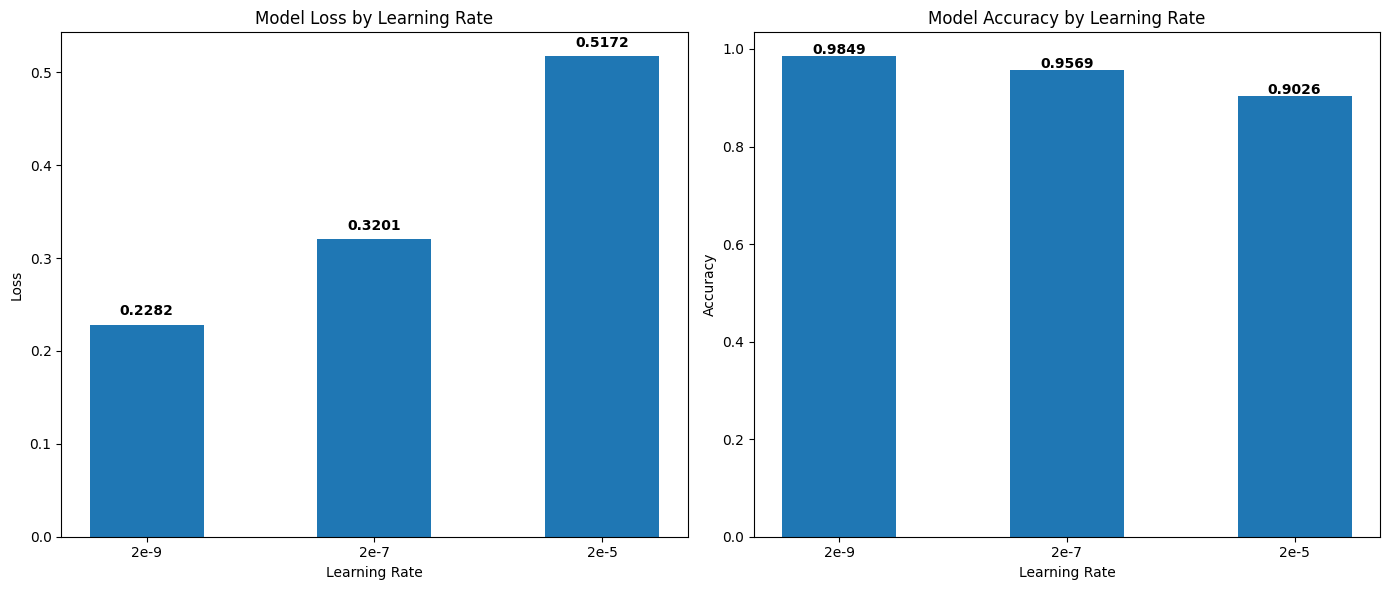

In [46]:
learning_rates = ["2e-9", "2e-7", "2e-5"]
losses = [0.2282, 0.3201, 0.5172]
accuracies = [0.9849, 0.9569, 0.9026]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss
axes[0].bar(learning_rates, losses, width=0.5)
axes[0].set_title("Model Loss by Learning Rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Loss")
for i, v in enumerate(losses):
    axes[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

# Plot Accuracy
axes[1].bar(learning_rates, accuracies, width=0.5)
axes[1].set_title("Model Accuracy by Learning Rate")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Accuracy")
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## Deployment on Huggingface

In [ ]:
from transformers import pipeline
tesxt = "I hate you"
classifier = pipeline("sentiment-analysis", model="SyedaAli32/hatespeechclassificationllm")

In [44]:
results = classifier(text)
print(results)

0: Hate Speech
